## Displacements due to pressure variations in Reservoir with arbitrary geometry and under arbitrary pressure changes

The reservoir model is a simplification of a realistic reservoir located in a production oil field in offshore Brazil

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import datetime
import compaction as cp
import pickle

In [2]:
with open("realistic_model.pickle", 'rb') as f:
    model_reservoir = pickle.load(f, encoding="bytes") 
    
model = model_reservoir['model']
DP    = model_reservoir['DP']


print(np.shape(model), np.shape(DP))
print (np.shape(model)[0])

assert np.shape(model)[0] == np.shape(DP)[0]

(364, 6) (364,)
364


In [3]:
model.shape

(364, 6)

### Young’s modulus $𝐸$ and Poisson's ratio $\nu$

In [4]:
# Young’s modulus (in MPa) 
young = 3300

# Poisson coefficient 
poisson = 0.25

### The uniaxial compaction coefficient $C_m$ 
$C_m = \frac{1}{E} \: \frac{(1 + \nu) (1  - 2\nu)}{(1-\nu)}$

In [5]:
cm = cp.Cm(poisson, young) # uniaxial compaction coefficient in 1/MPa
G = young/(2*(1+poisson)) # Shear Modulus in MPa
print ('CM', cm, 'G', G)

CM 0.0002525252525252525 G 1320.0


## Coordinates on the plane x =  8000m (north = 8000 m)

In [6]:
east_min  = 0.0
east_max = 13000
north_min = 0.0
north_max = 14000

In [7]:
#Pontos de observação
shape = (100, 80)
east_yz = np.linspace(east_min, east_max, shape[0])
z_yz = np.linspace(0, 4000., shape[1])
east_grid_yz, z_grid_yz = np.meshgrid(east_yz, z_yz)
east_yz = east_grid_yz.ravel()
z_yz = z_grid_yz.ravel()
north_yz = np.ones_like(east_yz)*8000
coordinates = np.vstack([east_yz, north_yz, z_yz])


### Compute the displacement components on plane x = 8000 m

In [8]:
# Compute the x-component of displacement

d_x1, d_x2, d_xz2 = cp.d_field_x_component(coordinates, model, DP, poisson, young)

displacement_x = d_x1 + (3 - 4*poisson)*d_x2 + d_xz2

# Compute the y-component of displacement

d_y1, d_y2, d_yz2 = cp.d_field_y_component(coordinates, model, DP, poisson, young)

displacement_y = d_y1 + (3 - 4*poisson)*d_y2 + d_yz2

# Compute the z-component of displacement

d_z1, d_z2, d_zz2 = cp.d_field_z_component(coordinates, model, DP, poisson, young)

displacement_z = d_z1 - (3 - 4*poisson)*d_z2 + d_zz2

In [9]:
# horizontal component of displacement equation (39)
displacement_horizontal = np.sqrt(displacement_x**2 + displacement_y**2)

### Save the data

In [10]:
fields_d_realistic_reservoir  = dict()
fields_d_realistic_reservoir['x'] = north_yz
fields_d_realistic_reservoir['y'] = east_yz
fields_d_realistic_reservoir['z'] = z_yz
# Displacement field
fields_d_realistic_reservoir['displacement_x'] = displacement_x
fields_d_realistic_reservoir['displacement_y'] = displacement_y 
fields_d_realistic_reservoir['displacement_z'] = displacement_z
fields_d_realistic_reservoir['displacement_horizontal'] = displacement_horizontal



In [11]:
#save the data
file_name = 'realistic_reservoir_displacement_fields_x_8000.pickle'
with open(file_name, 'wb') as f:
    pickle.dump(fields_d_realistic_reservoir, f)

## PLOT DISPLACEMENT FIELD BY OUR METHODOLOGY: 

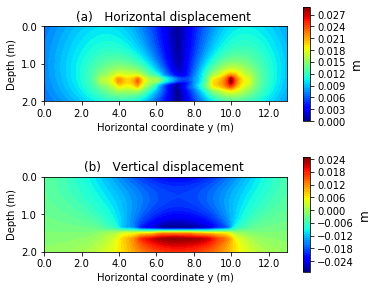

In [12]:
# Plot the displacement fields
y = np.linspace(east_min, east_max, shape[0])/1000. # in  km
z = np.linspace(0, 4000., shape[1])/1000. # in km

# Plot the displacement fields 
fig, ax = plt.subplots(nrows=2, ncols=1, sharex=False, sharey=False, figsize=(5.33,4.33))

ax[0].set_aspect("equal")
img = ax[0].contourf(y, z, displacement_horizontal.reshape(shape[::-1]), 
                  60, cmap="jet")
cb = plt.colorbar(img, ax=ax[0], aspect=15, pad=0.05, shrink=0.90)
cb.set_label('m', rotation=90, fontsize=12)
ax[0].set_title("(a)   Horizontal displacement ")

ax[0].set_xticklabels(ax[0].get_xticks())
ax[0].set_yticklabels(ax[0].get_yticks())
ax[0].invert_yaxis()
ax[0].set_xlabel("Horizontal coordinate y (m)")
ax[0].set_ylabel("Depth (m)")

ax[1].set_aspect("equal")
img = ax[1].contourf(y, z, displacement_z.reshape(shape[::-1]),  
                  60, cmap="jet")
cb = plt.colorbar(img, ax=ax[1], aspect=15, pad=0.05, shrink=0.90)
cb.set_label('m', rotation=90, fontsize=12)
ax[1].set_title("(b)   Vertical displacement ")

ax[1].set_xticklabels(ax[1].get_xticks())
ax[1].set_yticklabels(ax[1].get_yticks())
ax[1].invert_yaxis()
ax[1].set_xlabel("Horizontal coordinate y (m)")
ax[1].set_ylabel("Depth (m)")
plt.tight_layout(True)
plt.savefig('../manuscript/Fig/Figure_Displacement_complex_reservoir.png', dpi=600)

### THE STRESS FIELD BY OUR METHODOLOGY on plane z = 0 m

In [13]:
# Define computation points on the plane z = 0 m
shape = (60, 60)
y = np.linspace(east_min, east_max, shape[0])
x = np.linspace(north_min, north_max, shape[1])
y, x = np.meshgrid(y, x)
y = y.ravel()
x = x.ravel()
z = np.zeros_like(x)
coordinates = np.vstack([y, x, z])

In [14]:
# Compute the x-component of stress

s_xz1, s_xz2, s_xzz2 = cp.s_field_x_component(coordinates, model, DP, poisson, young)

stress_x = s_xz1 + s_xzz2 + s_xz2
#stress_x *= -young/(1 + poisson)  # perguntar ao Vanderlei Por que do Negativo 
stress_x *= young/(1 + poisson)


# Compute the y-component of stress

s_yz1, s_yz2, s_yzz2  = cp.s_field_y_component(coordinates, model, DP, poisson, young)

stress_y = s_yz1 + s_yzz2 + s_yz2
#stress_y *= -young/(1 + poisson)  # perguntar ao Vanderlei Por que do Negativo 
stress_y *= young/(1 + poisson)


# Compute the z-component of stress
s_zz1, s_zz2, s_zzz2 = cp.s_field_z_component(coordinates, model, DP, poisson, young)

stress_z = s_zz1 + s_zzz2 - s_zz2
#stress_z *= -young/(1 + poisson)  # perguntar ao Vanderlei Por que do Negativo 
stress_z *= young/(1 + poisson)

In [15]:
# horizontal component of stress
stress_horizontal = np.sqrt(stress_x**2 + stress_y**2)

### Plot the stress components on plane z = 0 m
### Reservoir under uniform depletion: (a) 𝑥−, (b) 𝑦−, and (c) 𝑧−components of the stress at the free surface¶

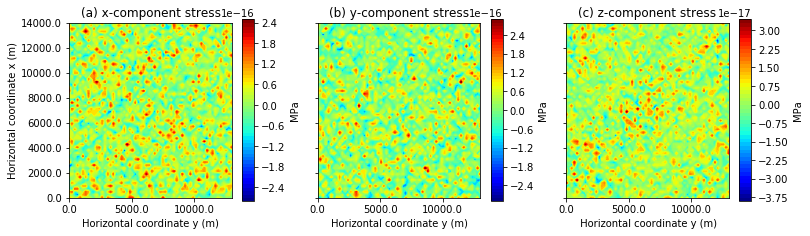

In [16]:
y = np.linspace(east_min, east_max, shape[0])
x = np.linspace(north_min, north_max, shape[1])

# Plot the results on a map
fig, ax = plt.subplots(nrows=1, ncols=3, sharex=False, sharey=True, figsize=(11.33, 5.33))

ax[0].set_aspect("equal")
img = ax[0].contourf(y, x, stress_x.reshape(shape), 
                  60, cmap="jet")

cb = plt.colorbar(img, ax=ax[0], aspect=15, pad=0.05, shrink=0.5)
cb.set_label('MPa', rotation=90, fontsize=10)

ax[0].set_title("(a) x-component stress")

ax[0].set_xticklabels(ax[0].get_xticks())
ax[0].set_yticklabels(ax[0].get_yticks())
ax[0].set_xlabel("Horizontal coordinate y (m)")
ax[0].set_ylabel("Horizontal coordinate x (m)")

ax[1].set_aspect("equal")
img = ax[1].contourf(y, x, stress_y.reshape(shape),  
                  60, cmap="jet")

cb = plt.colorbar(img, ax=ax[1], aspect=15, pad=0.05, shrink=0.5)
cb.set_label('MPa', rotation=90, fontsize=10)

ax[1].set_title("(b) y-component stress")

ax[1].set_xticklabels(ax[1].get_xticks())
ax[1].set_yticklabels(ax[1].get_yticks())
ax[1].set_xlabel("Horizontal coordinate y (m)")
#ax[1].set_ylabel("x (m)")

ax[2].set_aspect("equal")
img = ax[2].contourf(y, x, stress_z.reshape(shape),  
                  60, cmap="jet")
cb = plt.colorbar(img, ax=ax[2], aspect=15, pad=0.05, shrink=0.5)
cb.set_label('MPa', rotation=90, fontsize=10)

ax[2].set_title("(c) z-component stress")

ax[2].set_xticklabels(ax[2].get_xticks())
ax[2].set_yticklabels(ax[2].get_yticks())
ax[2].set_xlabel(" Horizontal coordinate y (m)")
#ax[2].set_ylabel("x (m)")

plt.tight_layout(True)
plt.savefig('../manuscript/Fig/Figure_Null_stress_complex_reservoir.png', dpi=600)